## Metric Learning and COBRA

This Notebook is going to be used only for experimenting with Metric Learning and Clustering to find out other ways to make COBRA tick.

Will use the same set-up as the other notebook (generic data).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import numpy as np
import pyCOBRA

In [2]:
# setting up our random data-set
# as of now this mirrors the COBRA sample code.
rng = np.random.RandomState(42)
# n_samples, n_features, n_train, n_epsilon = 800, 30, 600, 200

# D1 = train machines; D2 = create COBRA; D3 = calibrate epsilon, alpha; D4 = testing
n_features = 30
D1, D2, D3, D4 = 200, 200, 200, 200
D = D1 + D2 + D3 + D4
X = np.random.uniform(-1, 1, D * n_features).reshape(D, n_features)
Y = np.power(X[:,1], 2) + np.power(X[:,3], 3) + np.exp(X[:,10]) 
# + np.random.normal(size = n_samples)

# training data-set
X_train = X[:D1 + D2]
X_test = X[D1 + D2 + D3:D1 + D2 + D3 + D4]
X_eps = X[D1 + D2:D1 + D2 + D3]
# for testing
Y_train = Y[:D1 + D2]
Y_test = Y[D1 + D2 + D3:D1 + D2 + D3 + D4]
Y_eps = Y[D1 + D2:D1 + D2 + D3]

### Setting up COBRA

In [3]:
# set up our COBRA machine with the data
cobra = pyCOBRA.COBRA(train_design=X_train, train_responses=Y_train, epsilon = 0.50)

In [4]:
# we're now going to split our dataset into two parts
# shuffle data points
cobra.shuffle_data()
cobra.split_data(D1, D1 + D2)

In [5]:
# load the default machines to COBRA
cobra.loadDefault()

In [6]:
cobra.load_machine_predictions(all_predictions=True)

Now that we're sure it's loaded up properly, let's visualise the space we will be transforming.
It's the machine predictions we are concerned about.

Let's also better organise the input space: we wish to transform the prediction space. Let's create a matrix for this transformation, and then convert it back into a dictionary when we wish to plot!
We will later be using the indexes of the points chose of the machines so that we can use it to make predictions.

In [7]:
cobra.machine_predictions

{'lasso': array([ 1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647557,  1.44647557,  1.44647557,
         1.44647557,  1.44647557,  1.44647

The following plots may help us understand what the machine predictions which are being used to aggregate look like.
We plot sorted values, and subtract the 

In [8]:
def plot_prediction(machine_name):
    x = np.sort(np.abs(cobra.machine_predictions[machine_name] - cobra.machines[machine_name].predict(X_eps[0].reshape(1, -1))), axis=0)
    import matplotlib.pyplot as plt
    plt.plot(x)
    plt.show()

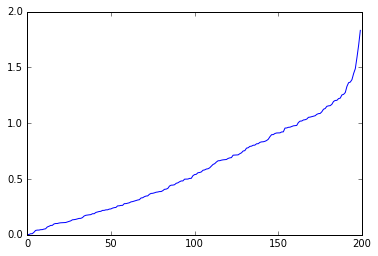

In [9]:
plot_prediction('ridge')

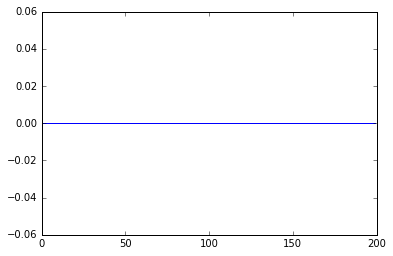

In [10]:
plot_prediction('lasso')

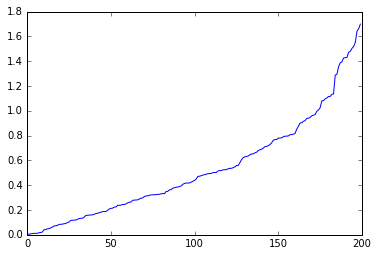

In [11]:
plot_prediction('random_forest')

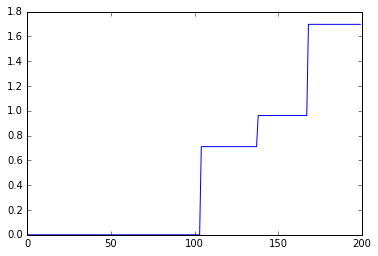

In [12]:
plot_prediction('tree')

Let's visualise our spaces; a before and after will be useful :)

In [13]:
def visualise(cobra, pred=None, linspace=None, plot_size=10, response=True):    
    """
    Try to keep info of each machine index versus name.
    """
    if linspace is None:
        linspace = x = np.linspace(0, len(cobra.train_l), len(cobra.train_l))
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    plt.figure(figsize=(plot_size, plot_size))    

    # colors = cm.rainbow(np.linspace(0, 1, len(self.cobra.machines)))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'purple', 'brown']
    
    if pred is None:
        pred = np.reshape(cobra.all_predictions, (4, 200))
    if response is True:
        plt.scatter(linspace, cobra.train_responses_l, color="pink")
    i = 0
    for machine, color in zip(pred, colors):
            plt.scatter(linspace, pred[i], color=color)
            i += 1
    plt.show()


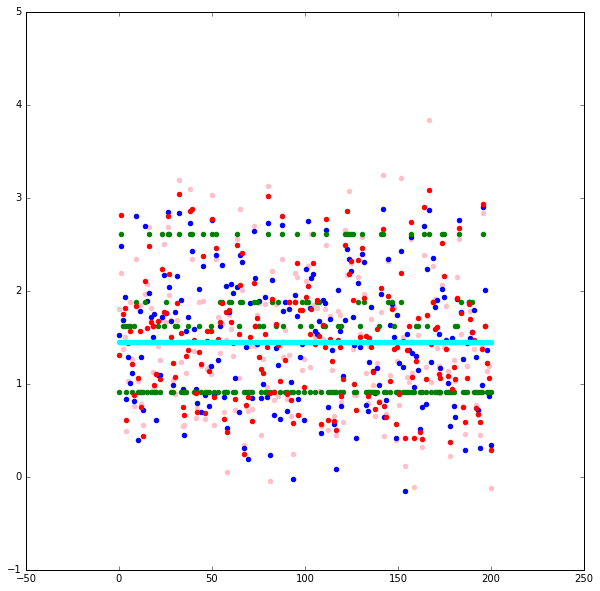

In [14]:
visualise(cobra)

### Metric Learning

Okay now that we've set up all our stuff, we can now focus purely on transorming the space, and in trying to get an epsilon-less COBRA!

Need to create the following : X, where D(X[a], X[b) < D(X[c], X[d)
In other words, make a set of similar and dissimilar vectors.

In [15]:
allp_0 = np.reshape(cobra.all_predictions, (4, 200)).T

In [16]:
allp_0[34], allp_0[35]

(array([ 0.94810353,  0.91364021,  0.74676222,  1.44647557]),
 array([ 0.45435406,  0.91364021,  0.66867109,  1.44647557]))

What does the above mean? The four machines made those 4 predictions for the 34th point. If ALL 4 of those predictions (or whatever the ideal value of M is) is 'close' to the real prediction (of it's machine), we pick that indice up. 
We want to eliminate the idea of distance in this closeness, so we pick up indices in a different manner.

So to reiterate: our primary goal is to pick up relevant indices.

We also want to get a new distance between points; and use clustering here (?), or infer an "ideal" epsilon using the matrix which transformed it. Must try both to see what the results look like. 

But, the points which we wish to transform are every individual point; by tracking indices we can do everything else.
Let's split it up and try some transformations.

In [17]:
allp_1 = np.reshape(cobra.all_predictions, (800, 1))

In [18]:
allp_1[34], allp_1[234], allp_1[434], allp_1[634]

(array([ 0.94810353]),
 array([ 0.91364021]),
 array([ 0.74676222]),
 array([ 1.44647557]))

`allp_1` is the matrix to be transformed. We now have to decide a way to create classes to do our transformation. 
Let's see if finding the average distance will be helpful.

In [19]:
avg = np.average(abs(np.diff(cobra.all_predictions)))

Let us use a crude way of transforming the space - points which are closer will be brought closer and points which are not will be pushed away.

In [20]:
def dissim(cobra, length=None):
    """
    Create arrays to be used for ITML, LSML metric learning.
    """
    allp_1 = np.reshape(cobra.all_predictions, (800, 1))
    avg = np.average(abs(np.diff(cobra.all_predictions)))
    import random
    sim = []
    dis = []
    count_0 = 0 
    count_1 = 0
    for point_0 in allp_1:
        count_1 = 0
        for point_1 in allp_1:
            if count_1 != count_0:
                sub = point_0 - point_1
                if abs(sub) < avg:
                    sim.append((count_0, count_1))
                else:
                    dis.append((count_0, count_1))
            count_1 += 1
        count_0 +=1
    
    if length is None:
        length = min(len(dis), len(sim))
    
    dis = np.array(random.sample(dis, length))
    sim = np.array(random.sample(sim, length))
    
    return sim[:,0], sim[:,1], dis[:,0], dis[:,1]

In [21]:
constraints = dissim(cobra, length=500)

Now that we have constraints ready, let's test it out.

In [22]:
import metric_learn

itml = metric_learn.ITML()
itml.fit(allp_1, constraints)
itml.metric()

/Users/bhargavvader/Dropbox/Bhargav/Code/venv/lib/python2.7/site-packages/metric_learn/itml.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = min(_lambda[i], gamma_proj*(1./wtw - 1./pos_bhat[i]))
/Users/bhargavvader/Dropbox/Bhargav/Code/venv/lib/python2.7/site-packages/metric_learn/itml.py:100: RuntimeWarning: invalid value encountered in double_scalars
  beta = alpha/(1 - alpha*wtw)
/Users/bhargavvader/Dropbox/Bhargav/Code/venv/lib/python2.7/site-packages/metric_learn/itml.py:101: RuntimeWarning: divide by zero encountered in double_scalars
  pos_bhat[i] = 1./((1 / pos_bhat[i]) + (alpha / gamma))
/Users/bhargavvader/Dropbox/Bhargav/Code/venv/lib/python2.7/site-packages/metric_learn/itml.py:101: RuntimeWarning: invalid value encountered in double_scalars
  pos_bhat[i] = 1./((1 / pos_bhat[i]) + (alpha / gamma))
/Users/bhargavvader/Dropbox/Bhargav/Code/venv/lib/python2.7/site-packages/metric_learn/itml.py:118: RuntimeWarning: invalid value encountered in doubl

array([[ nan]])

So, so far metric learning is not working at all; not with this method of creating constraints, at any rate. Raised an issue on GitHub to see if it is a common problem.

### Clustering + Metric Learning

Let's try and use clustering now - at least until we somehow fix metric learning. 

We have two ideas; use K-means to create labels, and use these labels to use in metric-learning because previous method did not work. Then try a Metric learning algo and see results.

The other is an alternate way, only using metric learning - which we will discuss a bit later.

In [23]:
from sklearn.cluster import KMeans

In [24]:
km = KMeans(n_clusters=5).fit(allp_1)

In [25]:
lmnn = metric_learn.LMNN()
lmnn.fit(allp_1, km.labels_)
lmnn.metric()

array([[ 342.7585534]])

So it does work; let's visualise the transformed space.

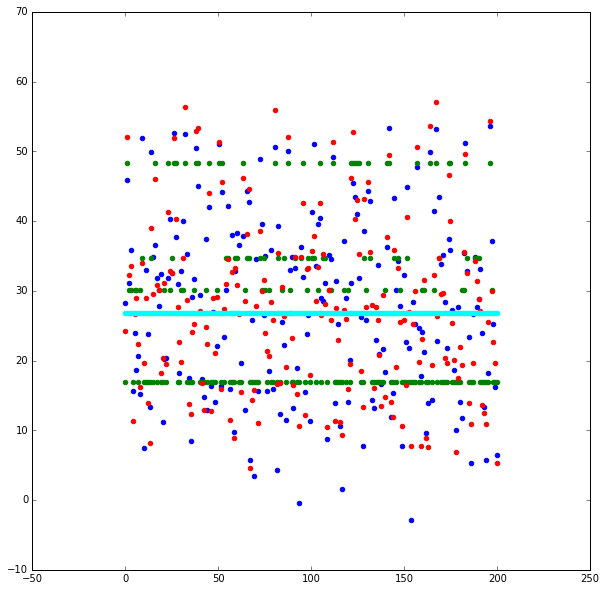

In [26]:
vis = lmnn.transform()
vis = np.reshape(vis, (4, 200))
visualise(cobra, pred=vis, response=False)

This looks extremely similar to our previous space; which makes sense, because the metric learned is just a single cell, and we are not actually 'transforming' our space.

We also take this time to wonder what sort of transformation is wanted, if not 

### Only clustering.

Experiment with clustering the prediction space. 

Possible algo for picking up indices (i.e, for a single point, prediction):

1. Create clusters of prediction space.
2. For a vector to predict, see which cluster the point belongs in and pick up all other points in that cluster.
3. Do this for each machine.
4. You have a collection of indices for each machine. Depending on value of 'M', pick up relevant indices.
5. Choose the relevant points from the the 'l' part of the data, similar to the current COBRA.

Now this algo will work much better after applying a Metric Learning algo. Also the 'kind' of clusters picked up will also matter a lot.

Just for a trial, let's see on average how many points are picked up when making a prediction.

In [27]:
cobra.predict_array(X_test, info=True, M=4)

(array([ 1.41926642,  1.82255144,  0.76133463,  1.12219082,  1.7798684 ,
         0.50750178,  1.56783216,  2.54173285,  2.58769338,  1.0817949 ,
         2.67834544,  1.61770551,  1.25140261,  0.81303178,  1.39918375,
         1.89004088,  0.38338003,  2.62083973,  2.39789732,  2.75429119,
         0.64340655,  1.17611845,  1.46478027,  2.03190374,  1.52057723,
         1.46184128,  0.92084368,  1.20161752,  1.32424867,  0.79168884,
         2.47903277,  0.7771578 ,  1.19714649,  0.41897733,  1.47522852,
         1.11027932,  0.94230409,  0.7549547 ,  1.3537965 ,  0.42766314,
         2.14860354,  1.07803201,  2.60313144,  0.7088586 ,  1.076736  ,
         1.0148938 ,  1.34567079,  0.72715551,  1.60434361,  0.60719285,
         2.32123822,  2.09999942,  1.32860965,  1.15192203,  2.87520965,
         1.5288137 ,  2.14754507,  1.64128555,  1.42952532,  1.50891674,
         2.14048571,  0.41185469,  1.28367898,  0.35983206,  2.71335564,
         1.55056532,  0.62240606,  1.8632091 ,  1.4

So we see an average of 29 points were used per prediction. This means that ideally, for our sized data-set, we should have more than 29 points in a cluster, so that enough points are picked up.

### Visualising Clusters

To better cluster our points, let's visualise them after being clustered.

In [28]:
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [29]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [30]:
clustering_names = ['Two Means', 'Spectral CLustering','DBSCAN', 'Affinity Propagation', 'Birch']

In [31]:
two_means = cluster.KMeans(n_clusters=6)
spectral = cluster.SpectralClustering(n_clusters=6, eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=.6)
affinity_propagation = cluster.AffinityPropagation(damping=.9, preference=-200)
birch = cluster.Birch(n_clusters=6)

In [32]:
clustering_algorithms = [two_means, spectral, dbscan, affinity_propagation, birch]

In [33]:
def plot_cluster(X, cobra, algo, linspace=None, plot_size=10):
    """
    Plot the data-set, colored with each point in the respective cluster.
    """
    if linspace is None:
        linspace = x = np.linspace(0, len(cobra.train_l), len(cobra.train_l))
    algo.fit(X)
    y_pred = np.reshape(algo.labels_, (4, 200))
    X_ = np.reshape(X, (4, 200))
    for i in range(0, len(X_)):
        plt.scatter(linspace, X_[i], color=colors[y_pred[i]].tolist())

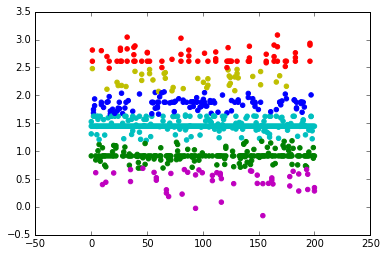

In [34]:
plot_cluster(allp_1, cobra, two_means)

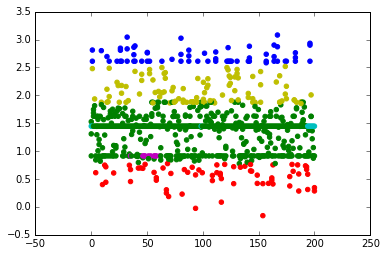

In [35]:
plot_cluster(allp_1, cobra, spectral)

After seeing the reuslts of clustering for all the algos, the best attempt seems to be K-means - but at any rate, we will drop this attempt and try our new attempt to combine metric learning and cobra - basically, point by point.

How to choose number of clusters? I still think that using metric learnign needs more thinking. 

In [36]:
def predict(cobra):
    """
    Alternate COBRA prediction algos
    """
    return

TODO

1. Plot the same thing, but for a M of machines
2. All points with all 4 machine used, should be similar (euclidean distance)
3. Points which have no common machines, should be dissimilar.
4. Support set algorithm.
5. legend in the plots.

TODO in diagnosis:

Sorted plot

Variations of how many points (10 - 90%) (in splitting)

Box plots - MSE and each machine